###Connect To Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/BioCV/assigment/TrainSet

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/BioCV/assigment/TrainSet


###import libraries

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.0 MB/s eta 0:00:00


In [ ]:
from glob import glob

import skimage.transform
import os
from scipy.ndimage import zoom
from skimage import exposure

import pydicom as dicom

import cv2
from PIL import Image

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
import math
from PIL import Image
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


###Import Images as Volumes

In [ ]:
root = "MR"
#root = "CT"

suff = "T1DUAL/DICOM_anon/InPhase/"
suff_GT = "T1DUAL/Ground/"
#suff = "DICOM_anon/"
dcm_ext = '.dcm'
png_ext = '.png'


paths = sorted(glob(os.path.join(root, "*", suff)))
paths_GT = sorted(glob(os.path.join(root, "*", suff_GT)))

print(f"Number of MR T1Dual InPhase volumes(patients): {len(paths)}")
print(f"Number of MR T1Dual GT: {len(paths_GT)}")

Number of MR T1Dual InPhase volumes(patients): 20
Number of MR T1Dual GT: 20


In [ ]:
img_vol_raw_list = []
vox_dim_list = []

for path in paths:
  img_vol = []
  for path, _, files in sorted(os.walk(path)):
    for filename in (sorted(files)):
        if filename.endswith (dcm_ext):
          #print (filename)
          img_dcm_std = dicom.dcmread(os.path.join(path,filename))

          img = img_dcm_std.pixel_array
          img_vol.append (img)
  #print(img_dcm_std)
  z_space = img_dcm_std.SpacingBetweenSlices
  x_space = img_dcm_std.PixelSpacing [0]
  y_space = img_dcm_std.PixelSpacing [1]
  vox_dim = (x_space, y_space, z_space)

  img_vol_raw_list.append(np.array(img_vol))
  vox_dim_list.append(vox_dim)
  print(f"Numero volumi: {len(img_vol_raw_list)}")

IMG-0004-00002.dcm
IMG-0004-00004.dcm
IMG-0004-00006.dcm
IMG-0004-00008.dcm
IMG-0004-00010.dcm
IMG-0004-00012.dcm
IMG-0004-00014.dcm
IMG-0004-00016.dcm
IMG-0004-00018.dcm
IMG-0004-00020.dcm
IMG-0004-00022.dcm
IMG-0004-00024.dcm
IMG-0004-00026.dcm
IMG-0004-00028.dcm
IMG-0004-00030.dcm
IMG-0004-00032.dcm
IMG-0004-00034.dcm
IMG-0004-00036.dcm
IMG-0004-00038.dcm
IMG-0004-00040.dcm
IMG-0004-00042.dcm
IMG-0004-00044.dcm
IMG-0004-00046.dcm
IMG-0004-00048.dcm
IMG-0004-00050.dcm
IMG-0004-00052.dcm
IMG-0004-00054.dcm
IMG-0004-00056.dcm
IMG-0004-00058.dcm
IMG-0004-00060.dcm
IMG-0004-00062.dcm
IMG-0004-00064.dcm
IMG-0004-00066.dcm
IMG-0004-00068.dcm
IMG-0004-00070.dcm
IMG-0046-00002.dcm
IMG-0046-00004.dcm
IMG-0046-00006.dcm
IMG-0046-00008.dcm
IMG-0046-00010.dcm
IMG-0046-00012.dcm
IMG-0046-00014.dcm
IMG-0046-00016.dcm
IMG-0046-00018.dcm
IMG-0046-00020.dcm
IMG-0046-00022.dcm
IMG-0046-00024.dcm
IMG-0046-00026.dcm
IMG-0046-00028.dcm
IMG-0046-00030.dcm
IMG-0046-00032.dcm
IMG-0046-00034.dcm
IMG-0046-000

In [ ]:
#load Ground Truth for MR T1Dual
img_vol_GT_list = []

for path in paths_GT:
  img_vol_GT = []
  for path, _, files in sorted(os.walk(path)):
    for filename in (sorted(files)):
        if filename.endswith (png_ext):
          #print (filename)
          img = np.array(Image.open(os.path.join(path,filename)))

          img_vol_GT.append (img)
  img_vol_GT_list.append(np.array(img_vol_GT))

In [ ]:
#Save 3 numpy arrays: img_vol_raw_list, vox_dim_list, img_vol_GT_list
np.savez('nparray-MR-T1DUAL-InPhase.npz', img_vol_raw_list=img_vol_raw_list, vox_dim_list=vox_dim_list, img_vol_GT_list=img_vol_GT_list)


In [ ]:
# Load .npz
loaded_data = np.load('nome_del_file.npz')

# Estrai gli array utilizzando i loro nomi specificati durante il salvataggio
img_vol_raw_list = loaded_data['img_vol_raw_list']
vox_dim_list = loaded_data['vox_dim_list']
img_vol_GT_list = loaded_data['img_vol_GT_list']

###Preprocessing

variabili:

* img_vol_GT_list

* img_vol_raw_list

* vox_dim_list


Nota: i volumi hanno dimensioni diverse. es: (50, 256, 256), (30, 288, 288), ..

Reseampling: porto i voxel in dimensioni 1x1x1. (anche per mask)

Resizing: reshape immagine 192x192x192 con inperpolatore=3 (per mask interpolatore=0)

Normalization: porto i valori tra 0 e 1 (solo per volumi, no maschere)

In [ ]:
def reseampling(vol, dim, my_order):
  target_resolution = (1, 1, 1)
  scale_vector = (dim[0]/target_resolution[0], dim[1]/target_resolution[1], dim[2]/target_resolution[2])
  vol_rescaled = skimage.transform.rescale(vol, scale_vector, order=my_order, preserve_range=True,  mode='constant')
  return vol_rescaled #, target_resolution

def resizing(vol, my_order):
  target_shape = [192, 192, 192]
  factors_1 = (
                target_shape[0]/vol.shape[0],
                target_shape[1]/vol.shape[1],
                target_shape[2]/vol.shape[2]
                )
  #print(f"Resizing factor: {factors_1}")
  return zoom(vol, factors_1, order=my_order, mode= 'nearest')

def normalization(vol): #min_max
  return cv2.normalize(vol, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [ ]:
vols =[]
vols_gt =[]
i=1
for vol, dim, vol_gt in zip(img_vol_raw_list,vox_dim_list,img_vol_GT_list):
  img = normalization(resizing(reseampling(vol,dim,3),3))
  img_GT = resizing(reseampling(vol_gt,dim,0),0)

  vols.append(img)
  vols_gt.append(img_GT)
  print(f"Processing volumes {i}/20")
  i=i+1

print(len(vols)), print(len(vols_gt))

Processing volumes 1/20
Processing volumes 2/20
Processing volumes 3/20
Processing volumes 4/20
Processing volumes 5/20
Processing volumes 6/20
Processing volumes 7/20
Processing volumes 8/20
Processing volumes 9/20
Processing volumes 10/20
Processing volumes 11/20
Processing volumes 12/20
Processing volumes 13/20
Processing volumes 14/20
Processing volumes 15/20
Processing volumes 16/20
Processing volumes 17/20
Processing volumes 18/20
Processing volumes 19/20
Processing volumes 20/20
20
20


(None, None)

vols[] e vols_gt[] sono liste lunghe 20 di np.narray (192,192,192).

Voglio concatenare tutte le slice e portarle nella forma: (20*192, 192, 192, 1)
Lo stesso vale per le maschere

In [ ]:
# Concatena gli array lungo l'asse 0 e aggiungi una dimensione alla fine
merged_vols = np.concatenate([arr[..., np.newaxis] for arr in vols], axis=0)

# Verifica la forma del risultato
print(merged_vols.shape)

(3840, 192, 192, 1)


In [ ]:
# Concatena gli array delle etichette lungo l'asse 0 e aggiungi una dimensione alla fine
merged_labels = np.concatenate([label[..., np.newaxis] for label in vols_gt], axis=0)

# Verifica la forma del risultato
print(merged_labels.shape)

(3840, 192, 192, 1)


In [ ]:
def map_category(value):
    if 55 <= value <= 70:
        return 1  # Liver
    elif 110 <= value <= 135:
        return 2  # Right kidney
    elif 175 <= value <= 200:
        return 3  # Left kidney
    elif 240 <= value <= 255:
        return 4  # Spleen
    else:
        return 0  # Unlabelled

In [ ]:
class_index_to_name = {
    0: 'Background',
    1: 'Liver',
    2: 'Right kidney',
    3: 'Left kidney',
    4: 'Spleen'
}

In [ ]:
# Applica la nuova mappatura a 'merged_labels'
merged_labels_04 = np.vectorize(map_category)(merged_labels)

# Conta il numero di classi uniche
unique_labels, counts = np.unique(merged_labels_04, return_counts=True)
print(unique_labels), print(counts)

[0 1 2 3 4]
[135138353   4600383    493318    515396    810310]


(None, None)

In [ ]:
def display_color_mapped_image_continuous(image, n_colors=5):
    """
    Display an image with colors mapped from a given image array using a continuous colormap.
    The image array should contain integer values from 0 to n_colors-1, where each integer
    represents a different color sampled linearly from the colormap.

    Args:
    image (ndarray): An array of shape (H, W) containing integer values from 0 to n_colors-1.
    n_colors (int): The number of colors to use from the colormap. Max 30.
    """
    if n_colors > 5:
        raise ValueError("Maximum number of colors is 5.")
    if not (0 <= image.min() and image.max() < n_colors):
        raise ValueError("Image values should be in the range [0, n_colors-1].")

    # Using a continuous colormap (like 'viridis') and sampling linearly
    cmap = plt.get_cmap('magma') #hot,magma,cividis
    colors = cmap(np.linspace(0, 1, n_colors))

    # Map the colors
    colored_image = colors[image]

    return colored_image

In [ ]:
def plot_pairs(data, labels, index=None):
    if index == None:
        index = np.random.randint(0,len(data))
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    axes[0].set_title("Image")
    axes[0].imshow(data[index])
    axes[1].set_title("Mask")
    colored_image = display_color_mapped_image_continuous(labels[index])
    axes[1].imshow(np.squeeze(colored_image))

  # Sovrapposizione della terza immagine con trasparenza
    axes[2].set_title("Overlay")
    axes[2].imshow(data[index])
    overlay_alpha = 0.5  # Regola il valore alpha a tuo piacimento
    axes[2].imshow(np.squeeze(colored_image), alpha=overlay_alpha)

    plt.show()
plot_pairs(merged_vols,merged_labels_04) #togli l indice[0,2839] per vedere immagini a caso

NameError: ignored

In [ ]:
#Save processed data: merged_vols, merged_labels_04
np.savez('processed-nparray-MR-T1DUAL-InPhase.npz', merged_vols=merged_vols, merged_labels_04=merged_labels_04)


In [ ]:
# Load .npz
loaded_data = np.load('processed-nparray-MR-T1DUAL-InPhase.npz')

# Estrai gli array utilizzando i loro nomi specificati durante il salvataggio
merged_vols = loaded_data['merged_vols']
merged_labels_04 = loaded_data['merged_labels_04']
print(merged_vols.shape), print(merged_labels_04.shape)

(3840, 192, 192, 1)
(3840, 192, 192, 1)


(None, None)

###U-Net

merged_vols, merged_labels_05 hanno shape:
(3840, 192, 192, 1)

In [ ]:
#num_classes=len(unique_labels)
num_classes =5
print(num_classes)

5


####Split data according to Patients (es. train: first 14 patients, val:15,16,17, test: 18,19,20)

In [ ]:
X_train = merged_vols[:14*192]
X_val = merged_vols[14*192:17*192]
X_test = merged_vols[17*192:]


y_train = merged_labels_04[:14*192]
y_val = merged_labels_04[14*192:17*192]
y_test = merged_labels_04[17*192:]

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2688, 192, 192, 1),
 (2688, 192, 192, 1),
 (576, 192, 192, 1),
 (576, 192, 192, 1),
 (576, 192, 192, 1),
 (576, 192, 192, 1))

In [ ]:
from sklearn.utils import shuffle

# Shuffling dei dati di addestramento
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

####Split data random (take all slices together and shuffle everything)

In [ ]:
# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(merged_vols, merged_labels_04, test_size=700, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=700, random_state=seed)

# Apply horizontal flip augmentation to the training set if specified
horizontal_flip = False

if horizontal_flip:
    X_train_flipped = np.flip(X_train, axis=2)
    X_train = np.concatenate([X_train, X_train_flipped], axis=0)
    y_train_flipped = np.flip(y_train, axis=2)
    y_train = np.concatenate([y_train, y_train_flipped], axis=0)

# Display the shapes of the resulting datasets
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2440, 192, 192, 1),
 (2440, 192, 192, 1),
 (700, 192, 192, 1),
 (700, 192, 192, 1),
 (700, 192, 192, 1),
 (700, 192, 192, 1))

####Architecture

In [ ]:
input_shape = X_train.shape[1:]
print('Input shape',input_shape)

Input shape (192, 192, 1)


In [ ]:
# Free some RAM
#del X, y, data, labels

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):

    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv'+str(i+1))(x)
        x = tfkl.BatchNormalization(name=name+'bn'+str(i+1))(x)
        x = tfkl.Activation(activation, name=name+'activation'+str(i+1))(x)

    return x

In [ ]:
def get_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # First Downsampling
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    # Second Downsampling
    down_block_2 = unet_block(d1, 128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Third Downsampling
    down_block_3 = unet_block(d2, 256, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Forth Downsampling
    down_block_4 = unet_block(d3, 512, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d4, 512, name='bottleneck')

    # First Upsampling (è simmetrico: il primo upsampling prende l ultimo downsampling)
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Add(name='add1')([u1,down_block_4]) #skip connection
    u1 = unet_block(u1, 256, name='up_block1_')

    # Second Upsampling
    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Add(name='add2')([u2,down_block_3])
    u2 = unet_block(u2, 128, name='up_block2_')

    # Third Upsampling
    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Add(name='add3')([u3,down_block_2])
    u3 = unet_block(u3, 64, name='up_block3_')

    # Forth Upsampling
    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Add(name='add4')([u4,down_block_1])
    u4 = unet_block(u4, 64, name='up_block4_')

    # Output Layer
    output_layer = tf.keras.layers.Conv2D(num_classes, kernel_size=3, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 192, 192, 1)]        0         []                            
                                                                                                  
 down_block1_conv1 (Conv2D)  (None, 192, 192, 64)         640       ['input_layer[0][0]']         
                                                                                                  
 down_block1_bn1 (BatchNorm  (None, 192, 192, 64)         256       ['down_block1_conv1[0][0]']   
 alization)                                                                                       
                                                                                                  
 down_block1_activation1 (A  (None, 192, 192, 64)         0         ['down_block1_bn1[0][0]'] 

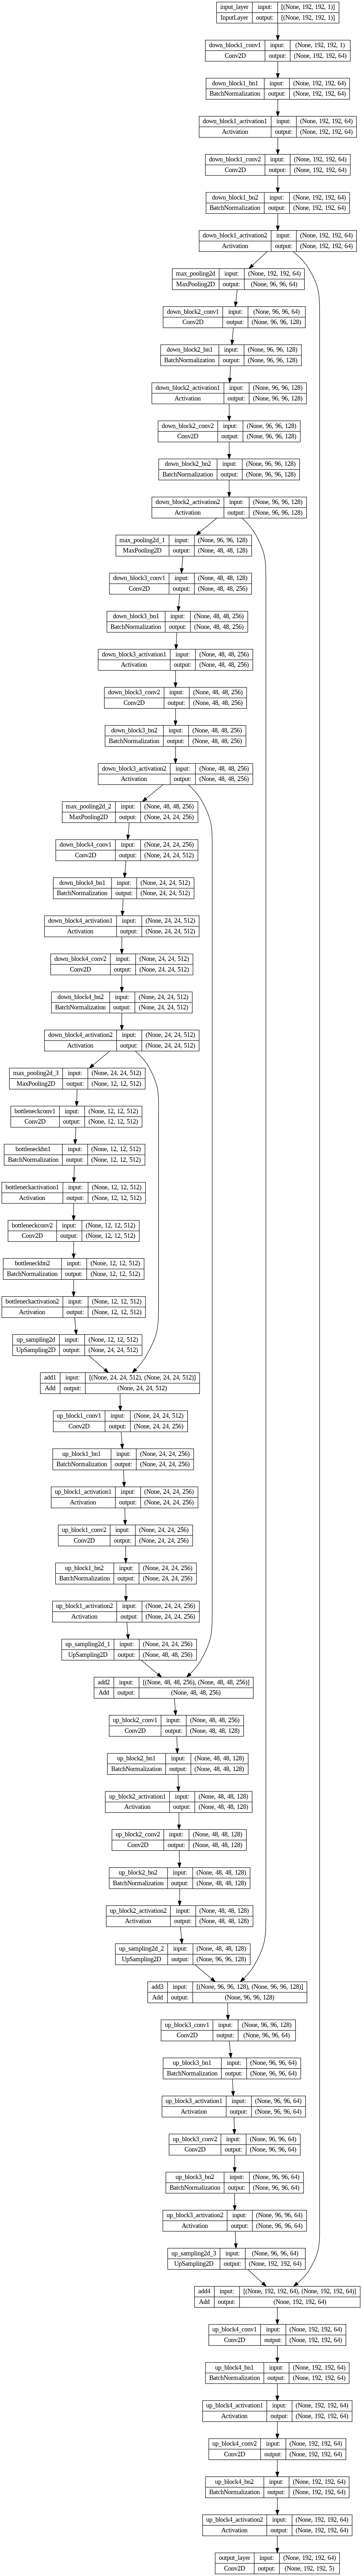

In [ ]:
model = get_unet_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

Custom Callbacks

In [ ]:
# Define a custom metric class for mean intersection over union (IoU)
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=None, name="mean_iou", dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# Define a callback class for visualization during training
class VizCallback(tf.keras.callbacks.Callback):

    def __init__(self, image, label):
        super().__init__()
        self.image = image
        self.label = label

    def on_epoch_end(self, epoch, logs=None):
        # Predict using the model and visualize ground truth vs predicted mask
        pred = model.predict(self.image, verbose=0)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (192, 192, 1)) #(128, 256, 1)
        fig, axes = plt.subplots(1, 2, figsize=(12, 12)) #(16, 4)
        axes[0].imshow(np.squeeze(self.label))
        axes[0].set_title("Ground Truth Mask")
        colored_image = display_color_mapped_image_continuous(y_pred)
        axes[1].imshow(np.squeeze(colored_image))
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

In [ ]:
learning_rate = 1e-3
batch_size = 16
epochs = 1000

In [ ]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tfk.optimizers.AdamW(learning_rate),
    metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes)]
    )

patience = 5
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_mean_iou', mode='max', patience=patience, restore_best_weights=True)
viz_callback = VizCallback(np.expand_dims(X_val[0],axis=0), np.expand_dims(y_val[0],axis=0))
scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', mode='max', factor=0.1, patience=patience-5, min_lr=1e-5)

Epoch 1/1000


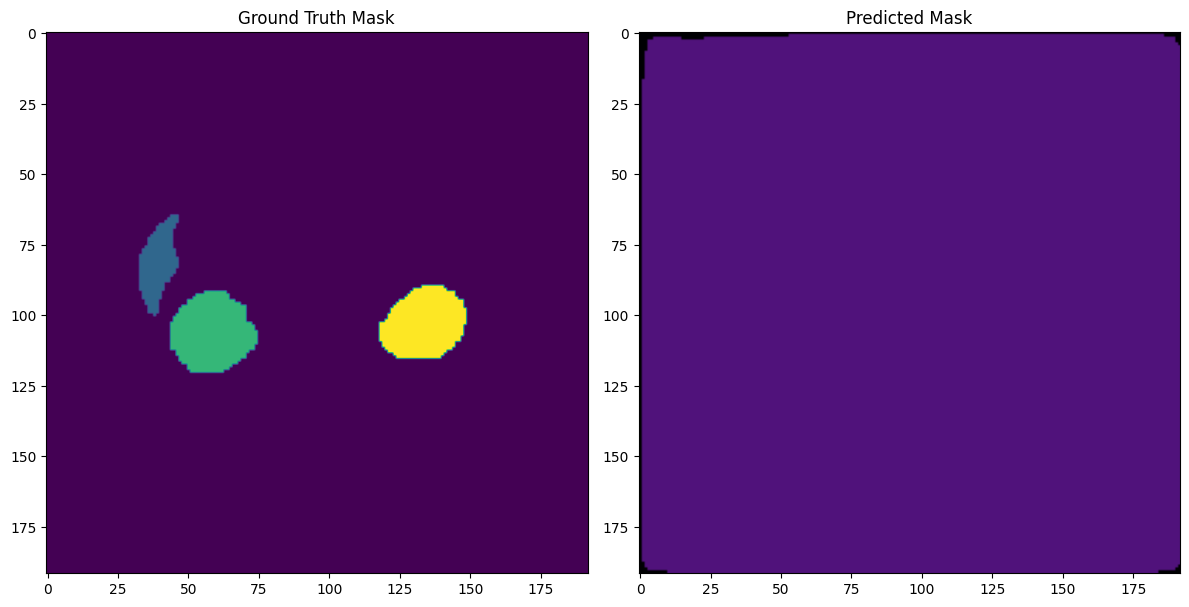

168/168 - 93s - loss: 0.1009 - accuracy: 0.9675 - mean_iou: 0.4371 - val_loss: 4.2364 - val_accuracy: 0.0437 - val_mean_iou: 0.0089 - lr: 0.0010 - 93s/epoch - 555ms/step
Epoch 2/1000


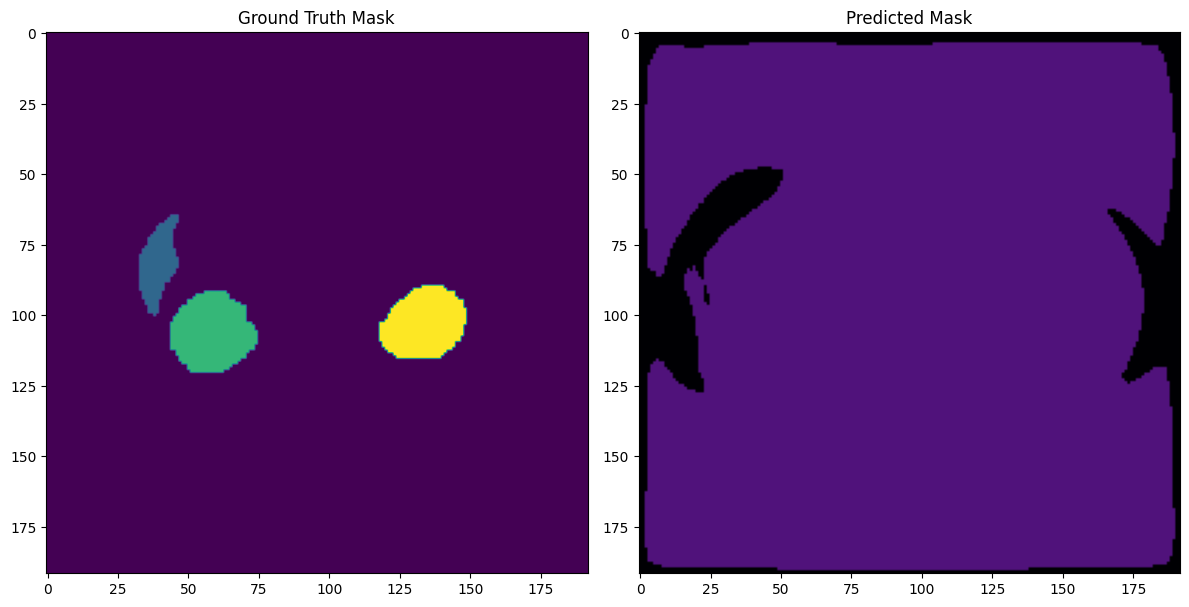

168/168 - 63s - loss: 0.0270 - accuracy: 0.9900 - mean_iou: 0.7862 - val_loss: 2.0957 - val_accuracy: 0.1708 - val_mean_iou: 0.0363 - lr: 0.0010 - 63s/epoch - 376ms/step
Epoch 3/1000


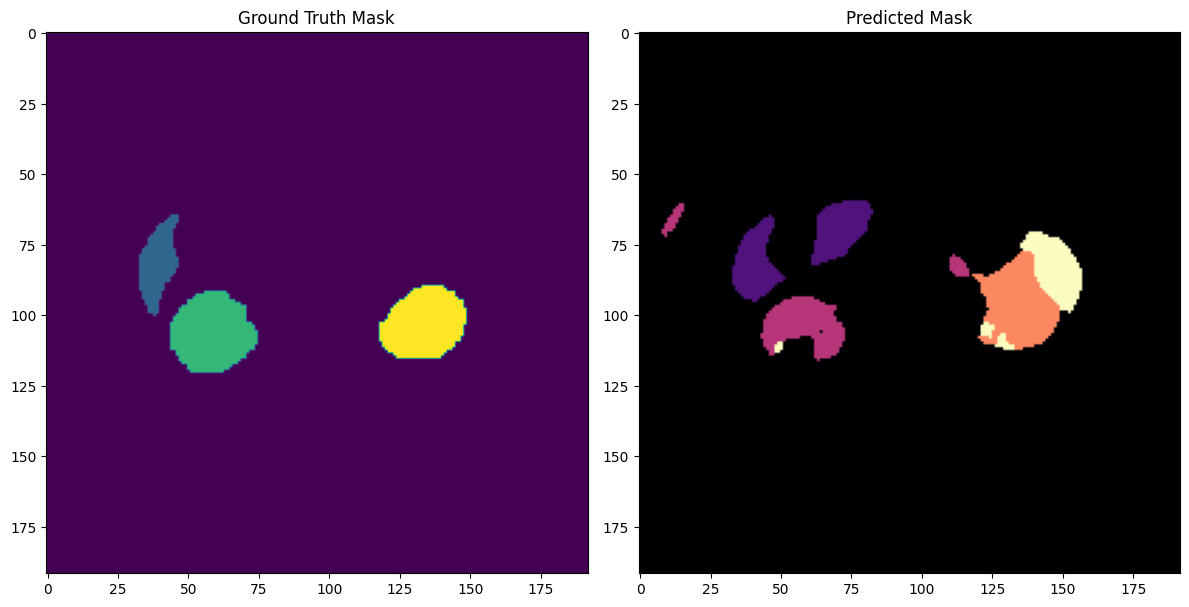

168/168 - 63s - loss: 0.0196 - accuracy: 0.9925 - mean_iou: 0.8476 - val_loss: 0.1928 - val_accuracy: 0.9398 - val_mean_iou: 0.4343 - lr: 0.0010 - 63s/epoch - 377ms/step
Epoch 4/1000


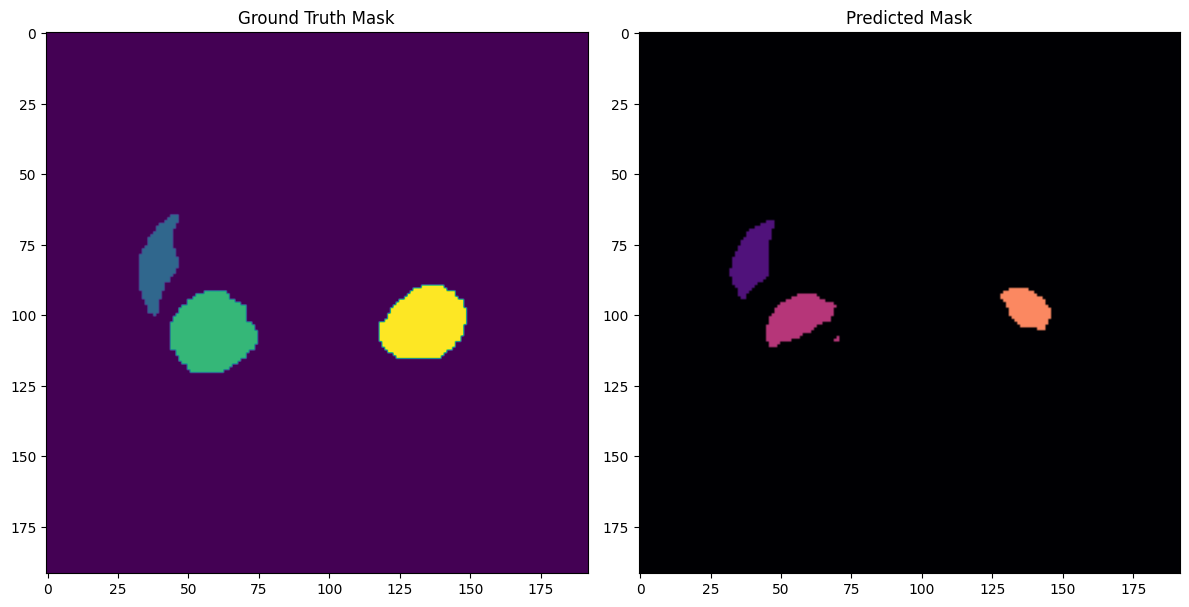

168/168 - 63s - loss: 0.0163 - accuracy: 0.9936 - mean_iou: 0.8694 - val_loss: 0.0673 - val_accuracy: 0.9800 - val_mean_iou: 0.5129 - lr: 0.0010 - 63s/epoch - 373ms/step
Epoch 5/1000


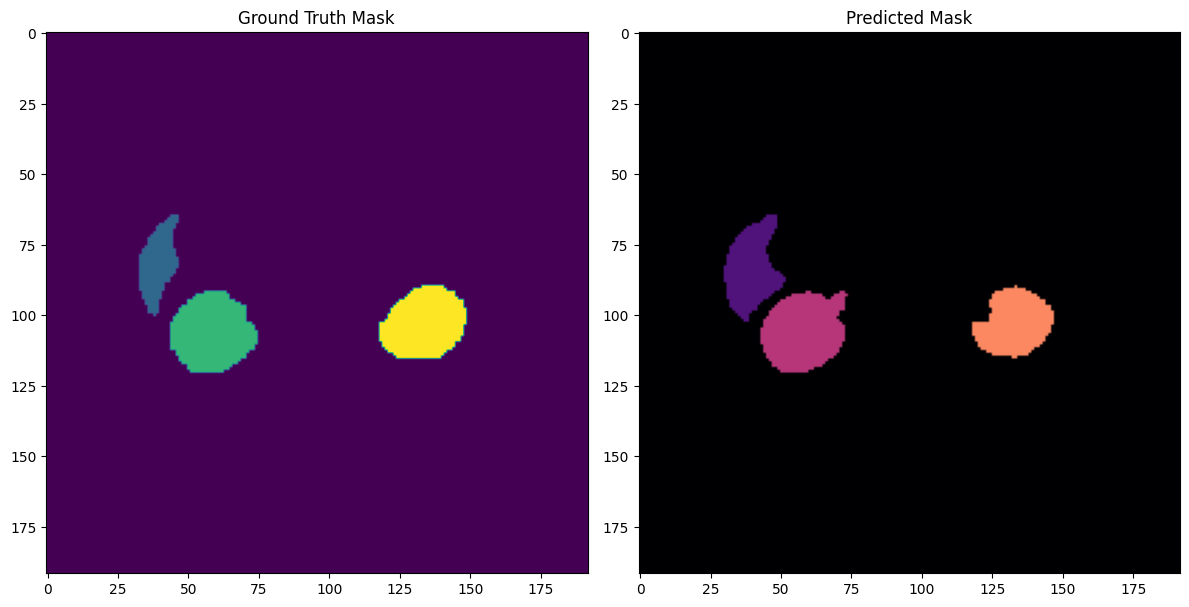

168/168 - 63s - loss: 0.0149 - accuracy: 0.9941 - mean_iou: 0.8798 - val_loss: 0.0364 - val_accuracy: 0.9876 - val_mean_iou: 0.7072 - lr: 0.0010 - 63s/epoch - 373ms/step
Epoch 6/1000


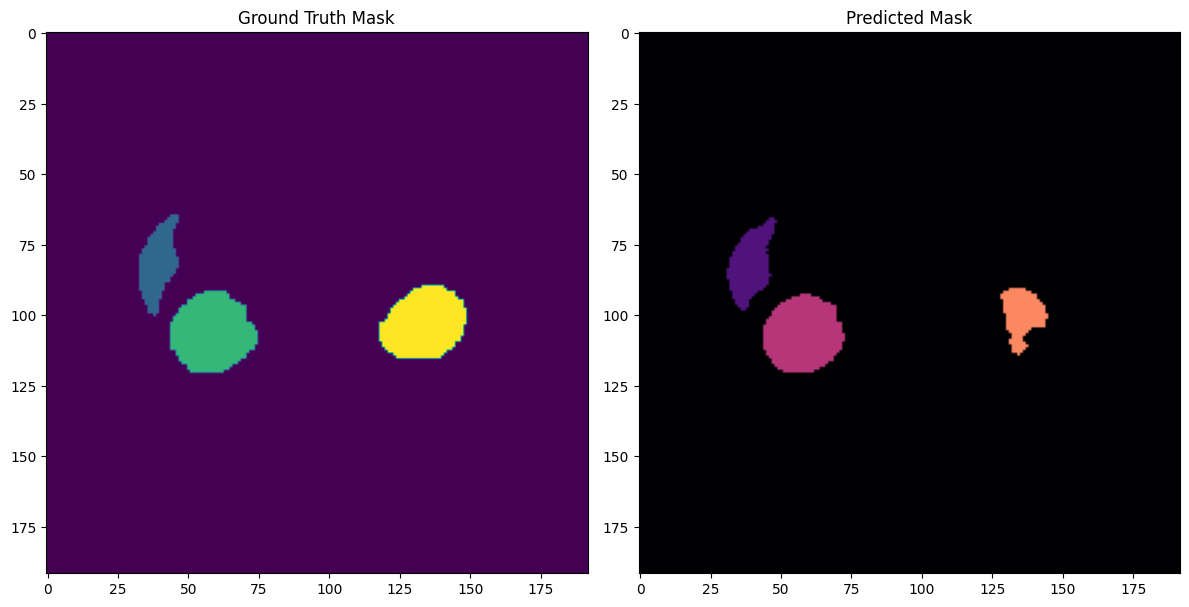

168/168 - 63s - loss: 0.0140 - accuracy: 0.9944 - mean_iou: 0.8840 - val_loss: 0.0477 - val_accuracy: 0.9863 - val_mean_iou: 0.6393 - lr: 0.0010 - 63s/epoch - 372ms/step
Epoch 7/1000


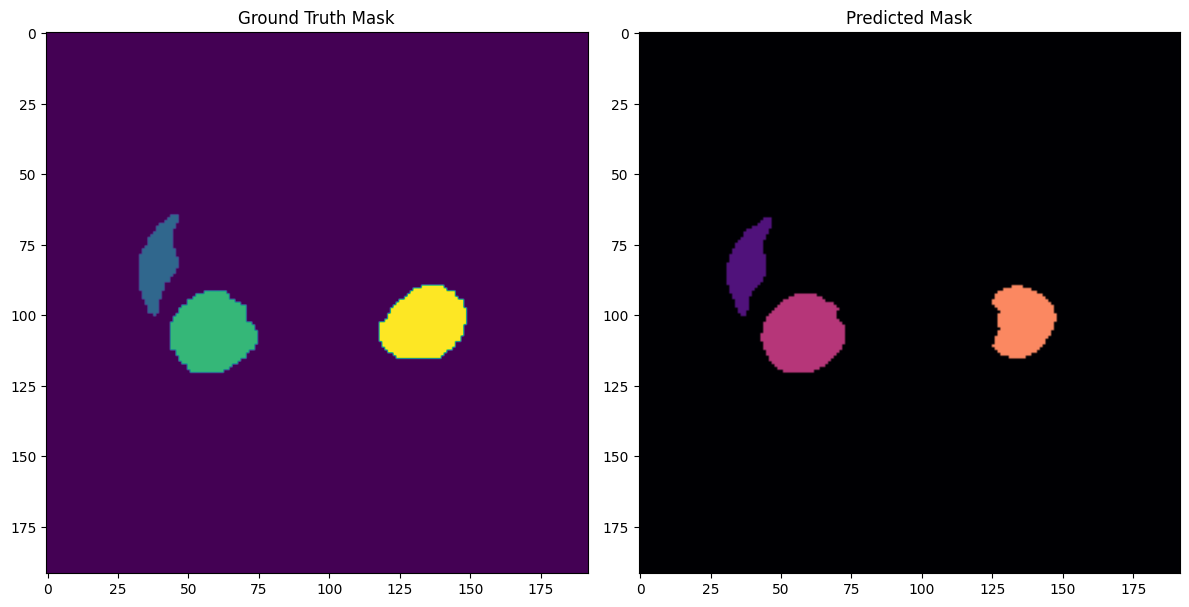

168/168 - 63s - loss: 0.0113 - accuracy: 0.9953 - mean_iou: 0.9035 - val_loss: 0.0323 - val_accuracy: 0.9899 - val_mean_iou: 0.7381 - lr: 1.0000e-04 - 63s/epoch - 373ms/step
Epoch 8/1000


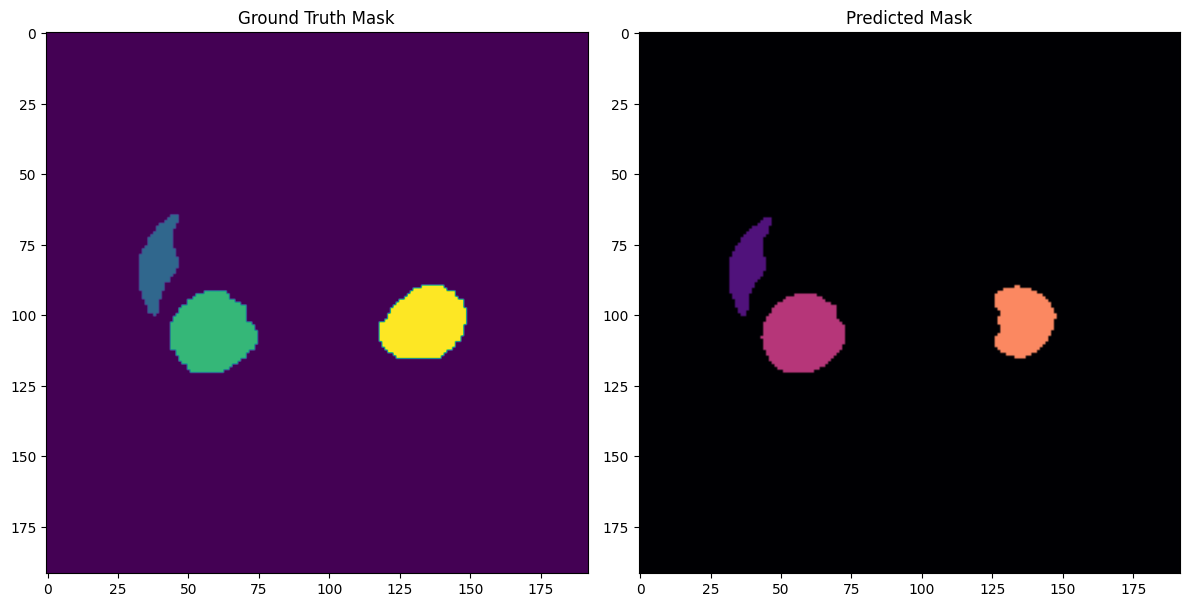

168/168 - 63s - loss: 0.0108 - accuracy: 0.9955 - mean_iou: 0.9073 - val_loss: 0.0330 - val_accuracy: 0.9900 - val_mean_iou: 0.7383 - lr: 1.0000e-04 - 63s/epoch - 374ms/step
Epoch 9/1000


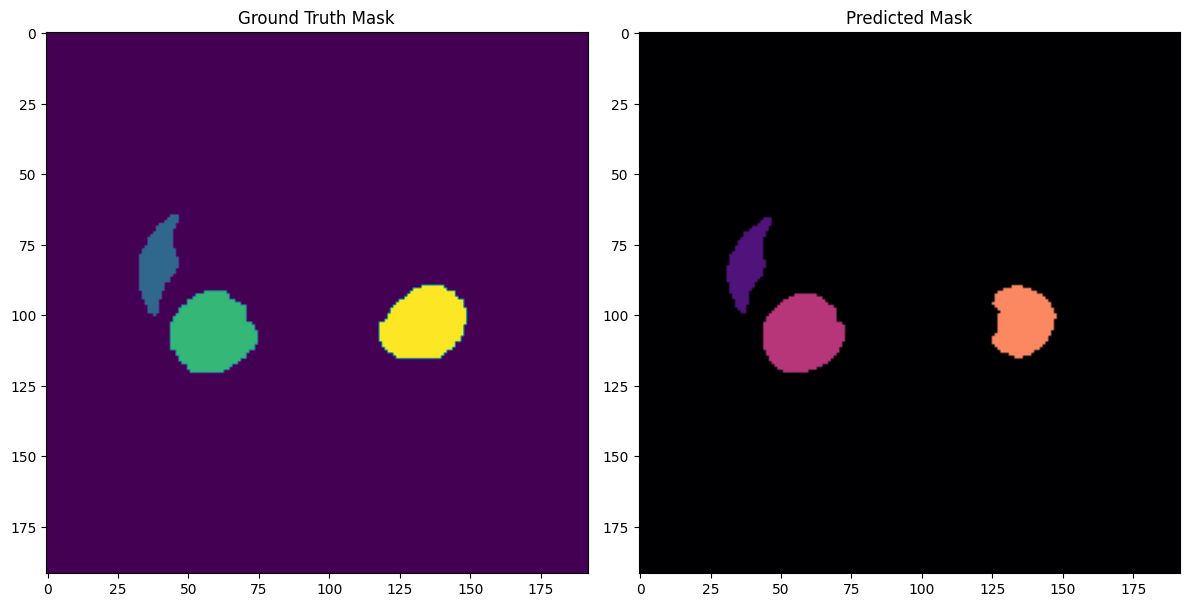

168/168 - 62s - loss: 0.0104 - accuracy: 0.9957 - mean_iou: 0.9102 - val_loss: 0.0341 - val_accuracy: 0.9899 - val_mean_iou: 0.7365 - lr: 1.0000e-04 - 62s/epoch - 367ms/step
Epoch 10/1000


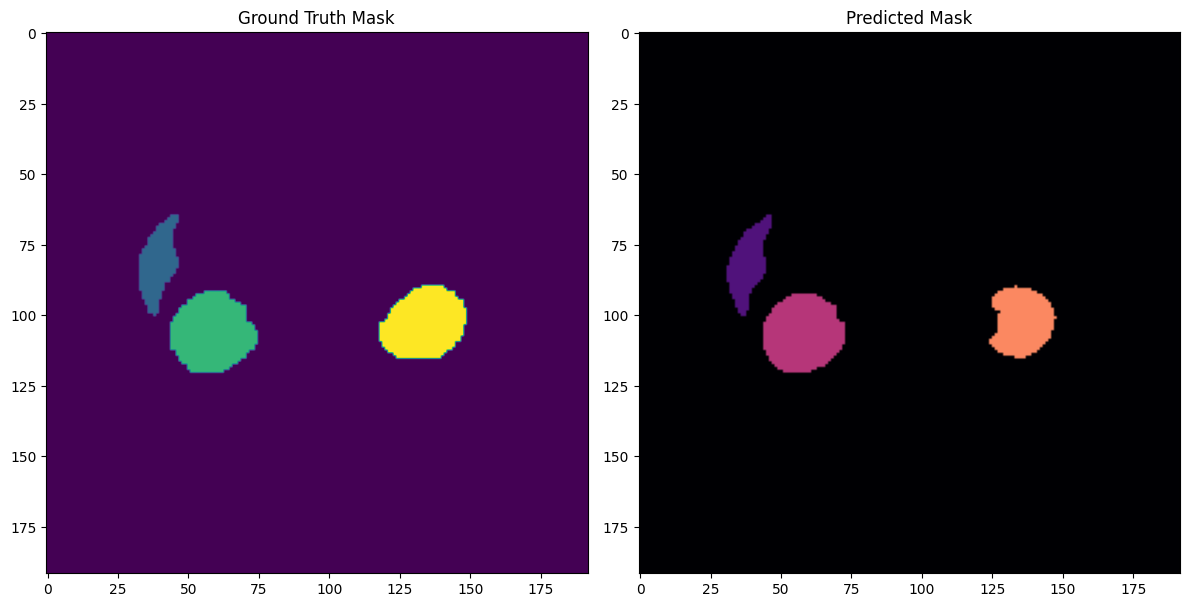

168/168 - 63s - loss: 0.0100 - accuracy: 0.9958 - mean_iou: 0.9127 - val_loss: 0.0333 - val_accuracy: 0.9901 - val_mean_iou: 0.7462 - lr: 1.0000e-05 - 63s/epoch - 375ms/step
Epoch 11/1000


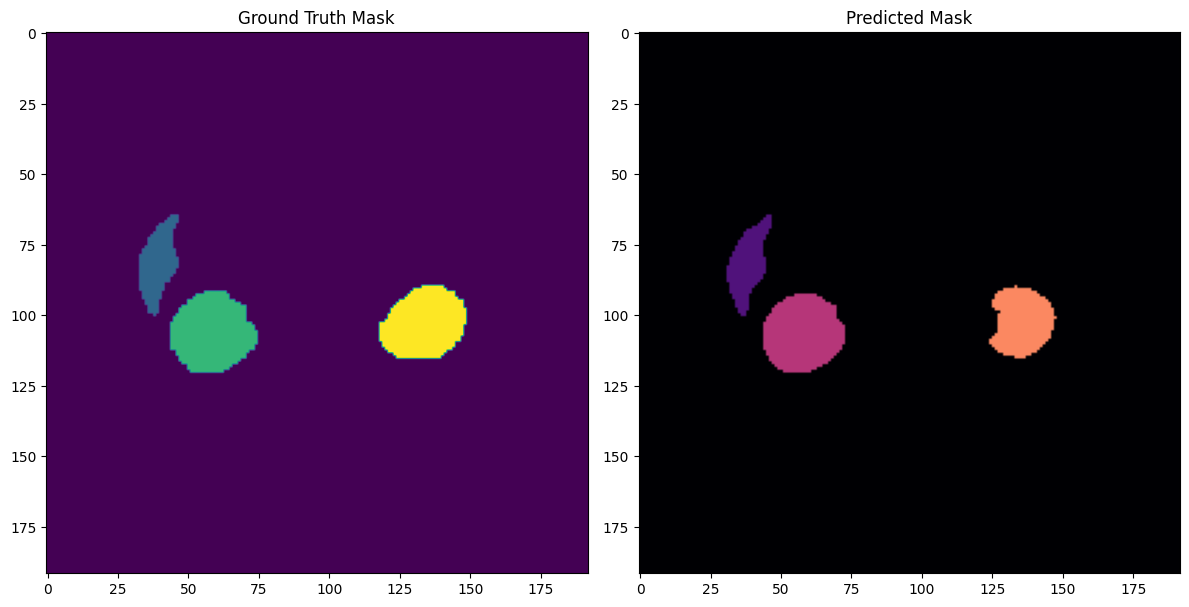

168/168 - 62s - loss: 0.0100 - accuracy: 0.9958 - mean_iou: 0.9128 - val_loss: 0.0336 - val_accuracy: 0.9900 - val_mean_iou: 0.7448 - lr: 1.0000e-05 - 62s/epoch - 367ms/step
Epoch 12/1000


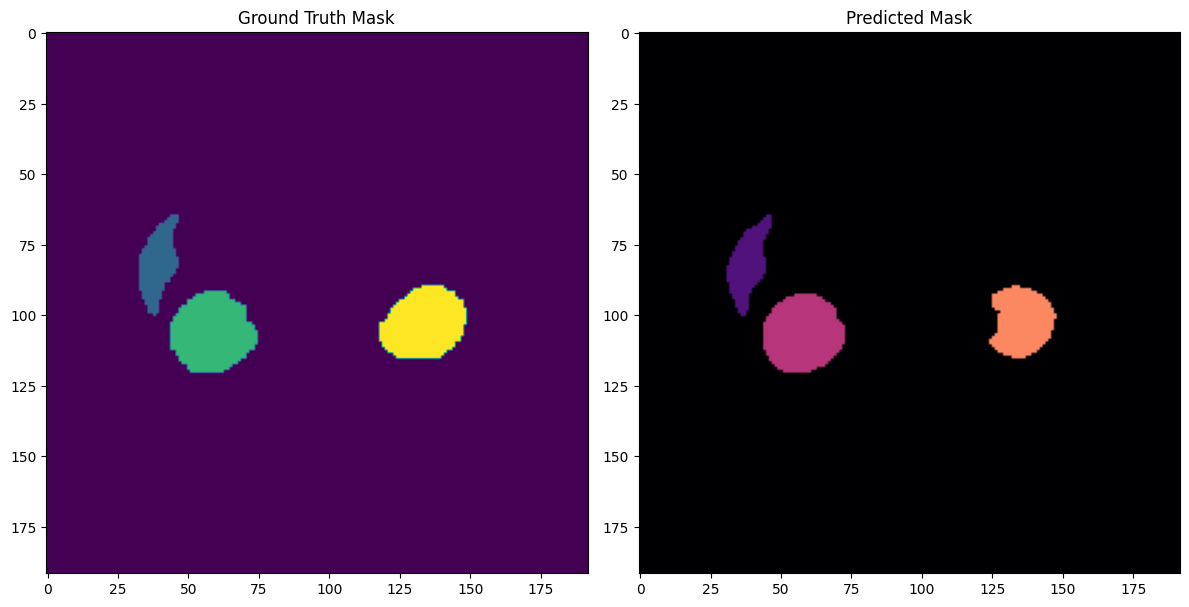

168/168 - 62s - loss: 0.0099 - accuracy: 0.9959 - mean_iou: 0.9132 - val_loss: 0.0335 - val_accuracy: 0.9901 - val_mean_iou: 0.7483 - lr: 1.0000e-05 - 62s/epoch - 367ms/step
Epoch 13/1000


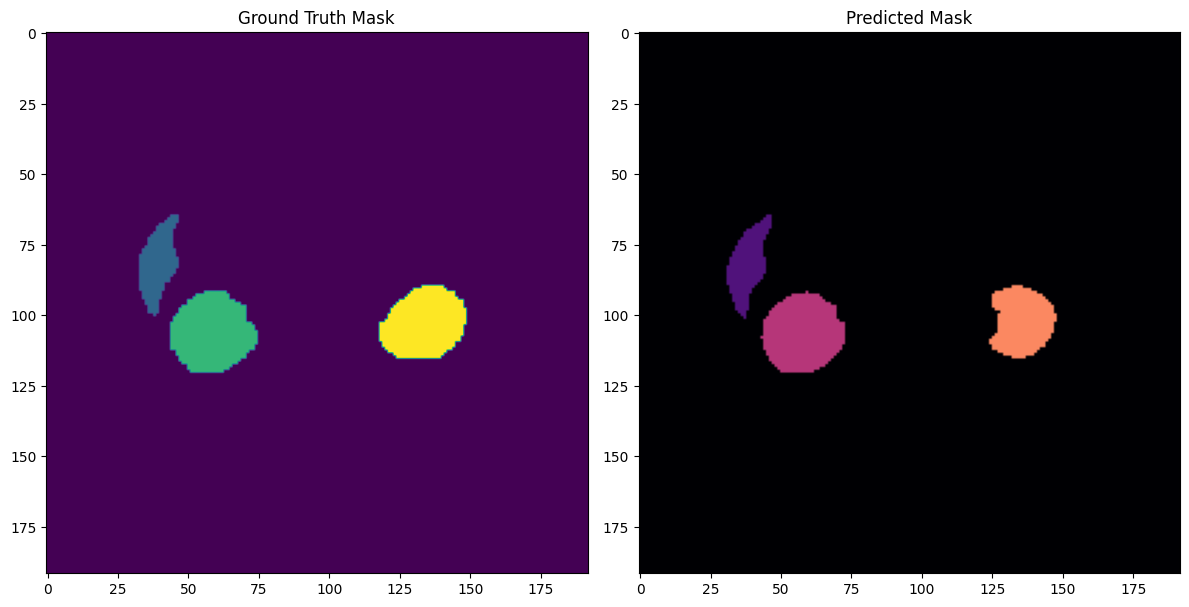

168/168 - 61s - loss: 0.0098 - accuracy: 0.9959 - mean_iou: 0.9139 - val_loss: 0.0332 - val_accuracy: 0.9901 - val_mean_iou: 0.7541 - lr: 1.0000e-05 - 61s/epoch - 365ms/step
Epoch 14/1000


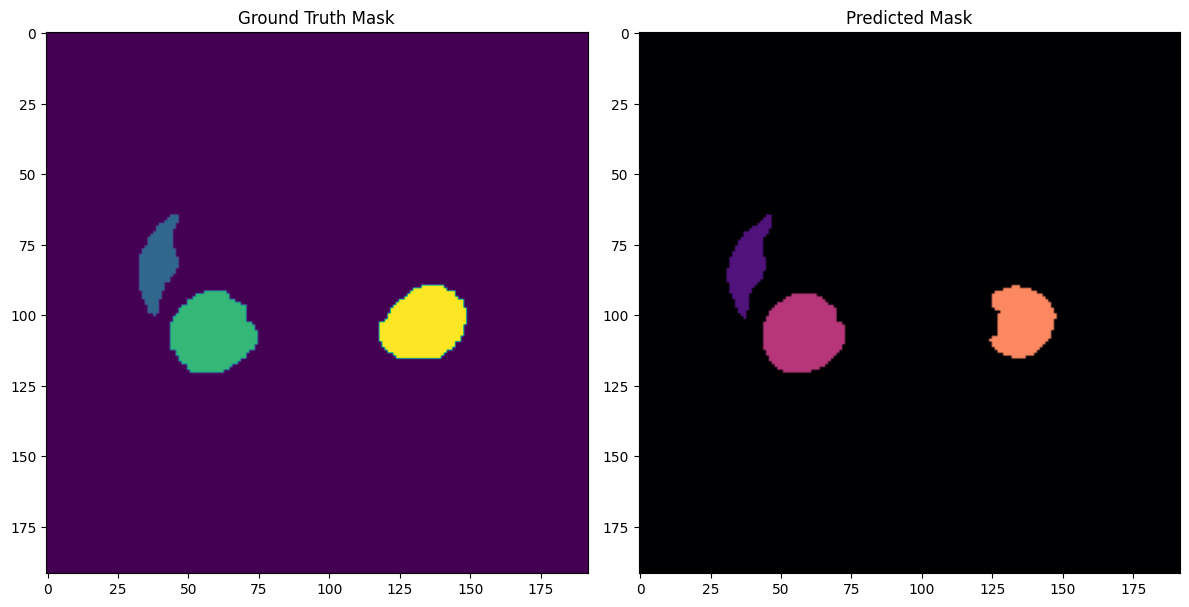

168/168 - 61s - loss: 0.0098 - accuracy: 0.9959 - mean_iou: 0.9138 - val_loss: 0.0337 - val_accuracy: 0.9901 - val_mean_iou: 0.7488 - lr: 1.0000e-05 - 61s/epoch - 364ms/step
Epoch 15/1000


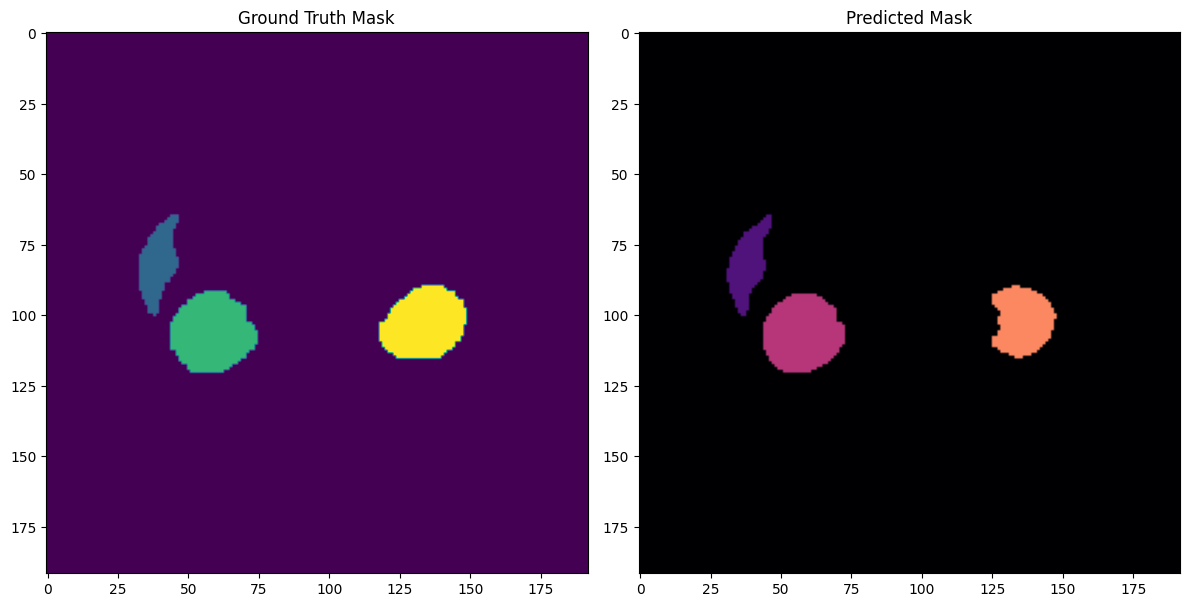

168/168 - 63s - loss: 0.0098 - accuracy: 0.9959 - mean_iou: 0.9140 - val_loss: 0.0339 - val_accuracy: 0.9901 - val_mean_iou: 0.7452 - lr: 1.0000e-05 - 63s/epoch - 372ms/step
Epoch 16/1000


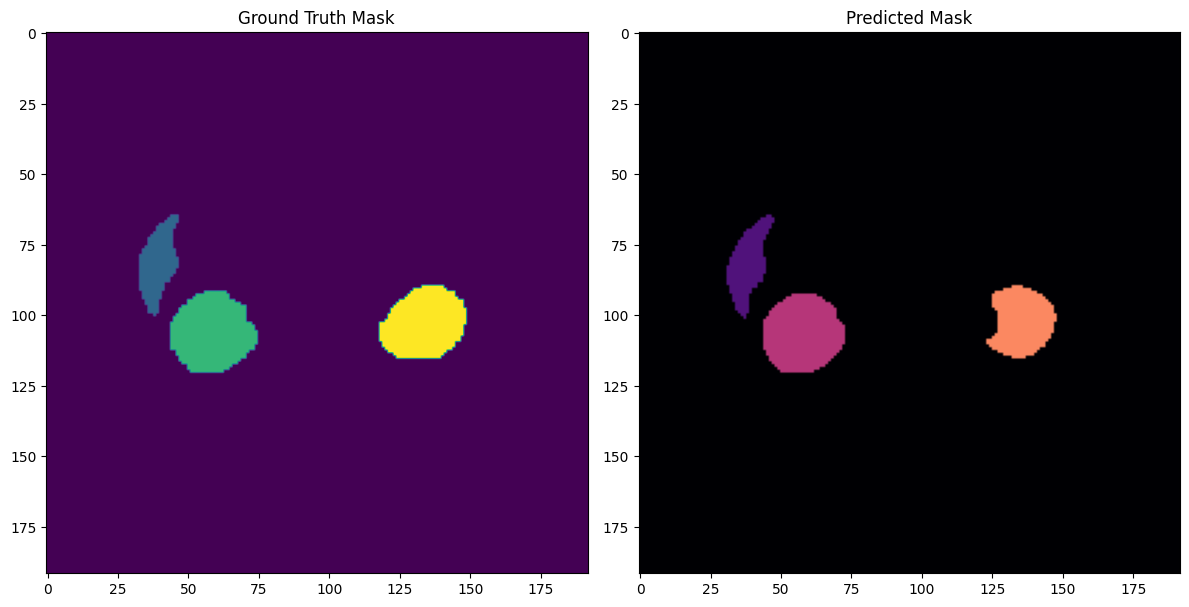

168/168 - 63s - loss: 0.0097 - accuracy: 0.9959 - mean_iou: 0.9143 - val_loss: 0.0333 - val_accuracy: 0.9902 - val_mean_iou: 0.7542 - lr: 1.0000e-05 - 63s/epoch - 372ms/step
Epoch 17/1000


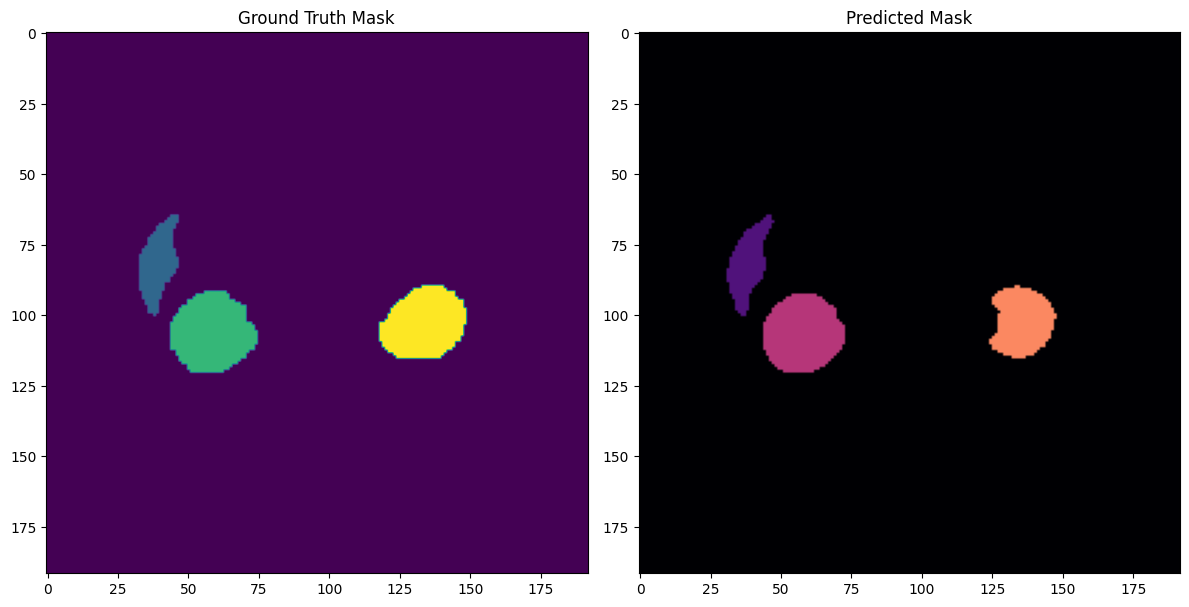

168/168 - 61s - loss: 0.0097 - accuracy: 0.9960 - mean_iou: 0.9148 - val_loss: 0.0341 - val_accuracy: 0.9901 - val_mean_iou: 0.7486 - lr: 1.0000e-05 - 61s/epoch - 365ms/step
Epoch 18/1000


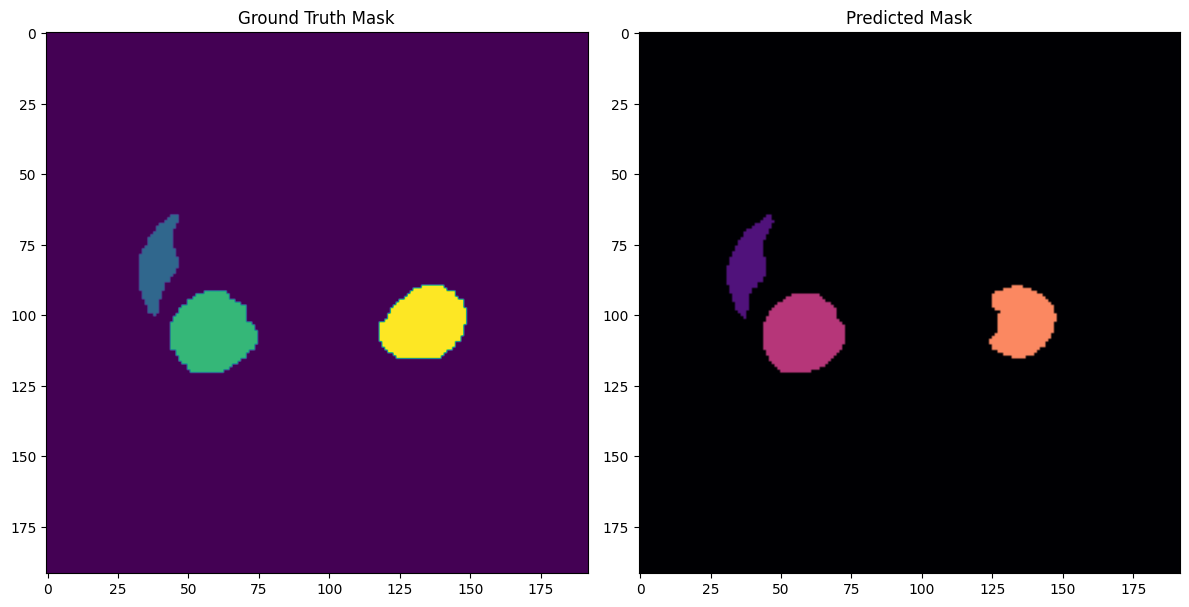

168/168 - 63s - loss: 0.0096 - accuracy: 0.9960 - mean_iou: 0.9153 - val_loss: 0.0341 - val_accuracy: 0.9901 - val_mean_iou: 0.7524 - lr: 1.0000e-05 - 63s/epoch - 372ms/step
Epoch 19/1000


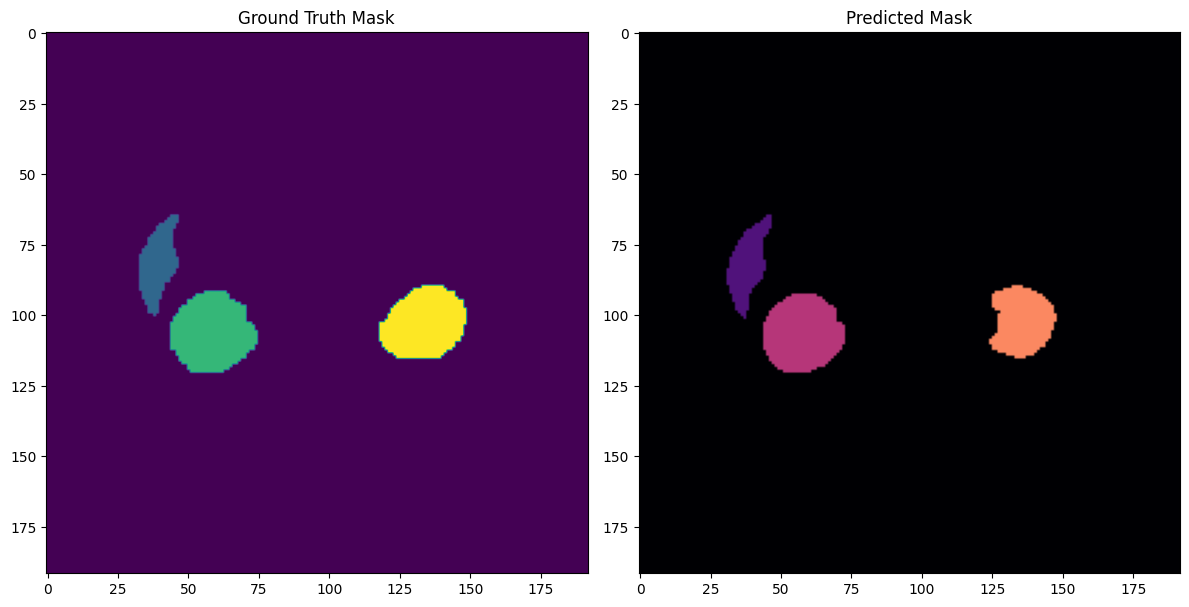

168/168 - 61s - loss: 0.0096 - accuracy: 0.9960 - mean_iou: 0.9156 - val_loss: 0.0344 - val_accuracy: 0.9900 - val_mean_iou: 0.7490 - lr: 1.0000e-05 - 61s/epoch - 365ms/step
Epoch 20/1000


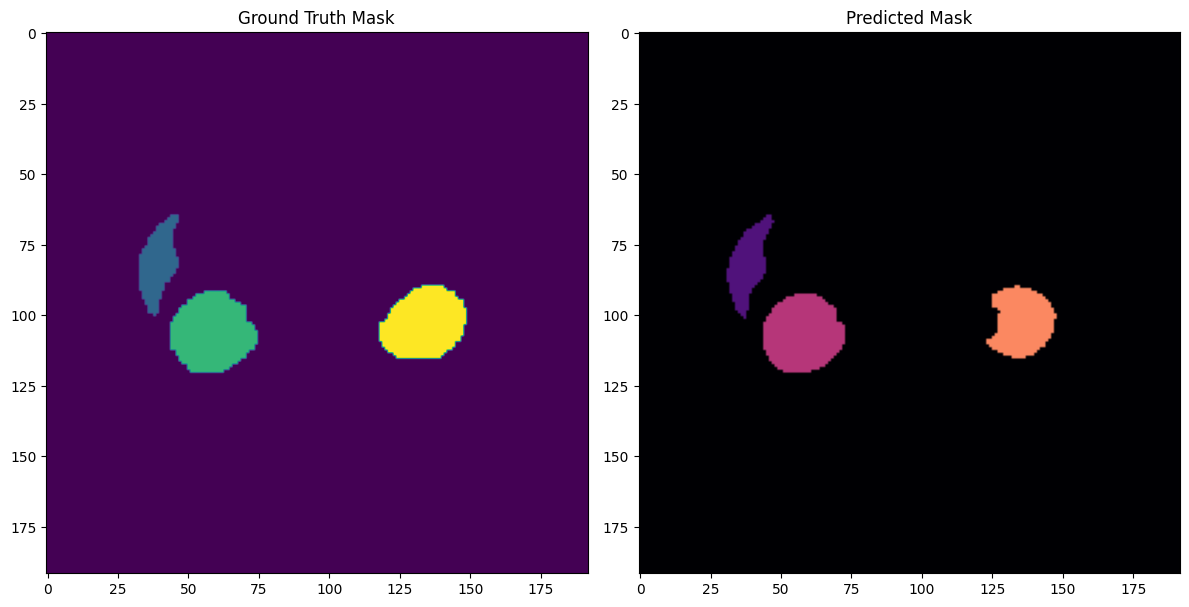

168/168 - 63s - loss: 0.0095 - accuracy: 0.9960 - mean_iou: 0.9158 - val_loss: 0.0344 - val_accuracy: 0.9901 - val_mean_iou: 0.7497 - lr: 1.0000e-05 - 63s/epoch - 372ms/step
Epoch 21/1000


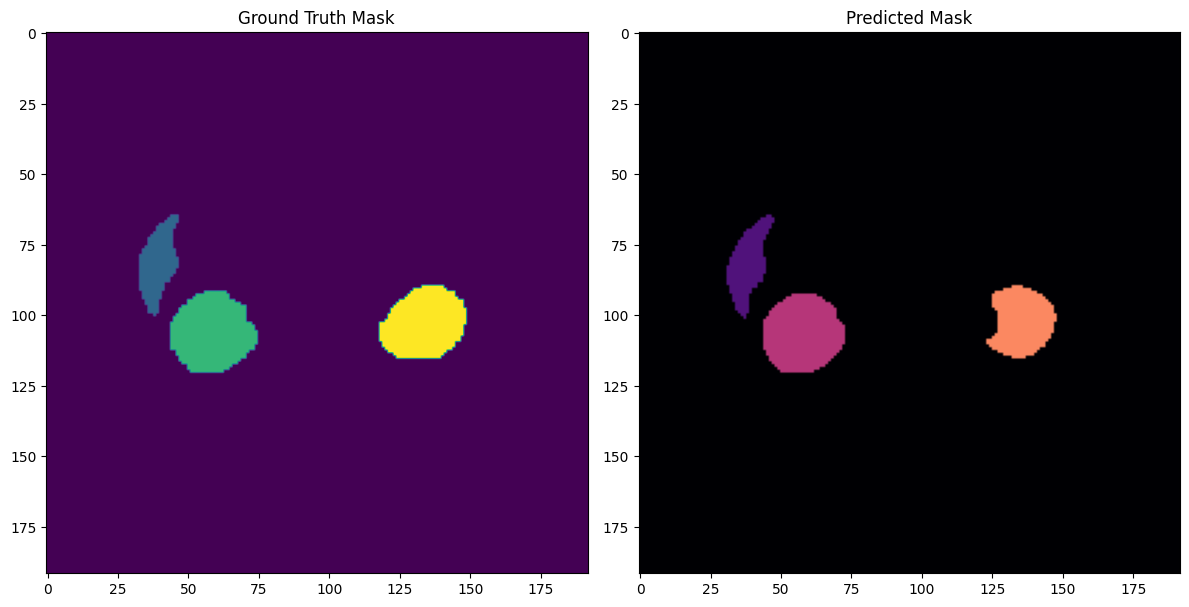

168/168 - 62s - loss: 0.0095 - accuracy: 0.9960 - mean_iou: 0.9166 - val_loss: 0.0343 - val_accuracy: 0.9900 - val_mean_iou: 0.7490 - lr: 1.0000e-05 - 62s/epoch - 368ms/step


In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_val, y_val),
    callbacks=[early_stopping, viz_callback, scheduler],
    verbose=2
    )

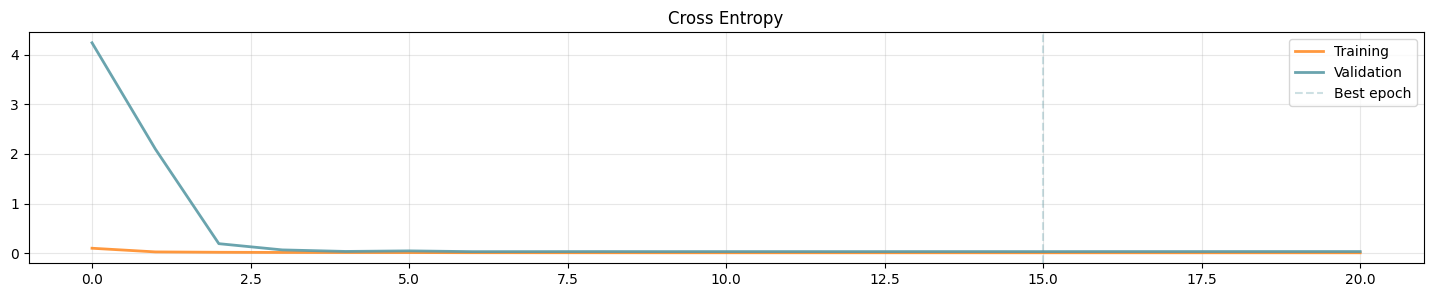

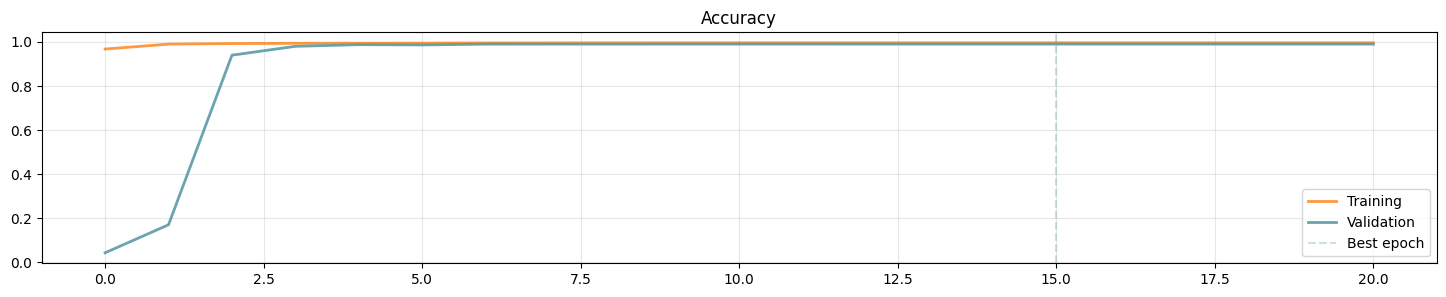

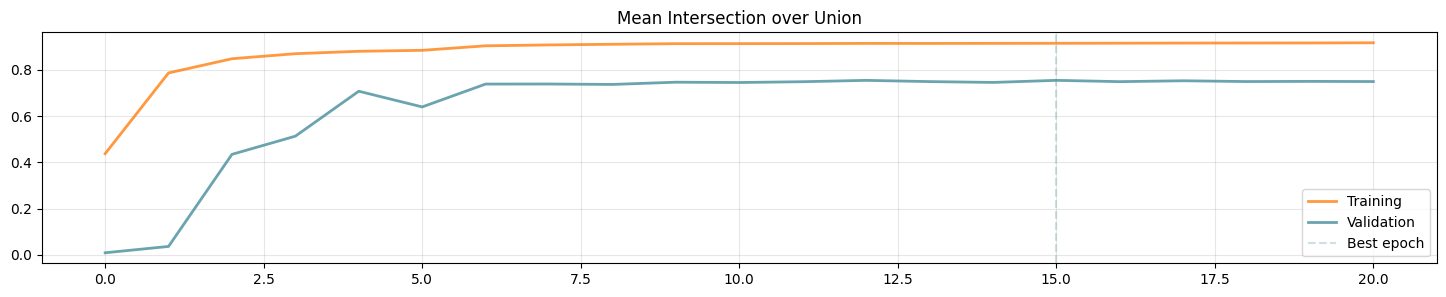

In [ ]:
best_epoch = np.argmax(history.history['val_mean_iou'])
plt.figure(figsize=(18,3))
plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['mean_iou'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_mean_iou'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('UNet-SplittedByPatients')
#del model

###Make Inference

In [ ]:
# Load UNet model without compiling
model = tfk.models.load_model('UNet-SplittedByPatients', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=["accuracy", UpdatedMeanIoU(num_classes=num_classes)]
)

# Display the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 192, 192, 1)]        0         []                            
                                                                                                  
 down_block1_conv1 (Conv2D)  (None, 192, 192, 64)         640       ['input_layer[0][0]']         
                                                                                                  
 down_block1_bn1 (BatchNorm  (None, 192, 192, 64)         256       ['down_block1_conv1[0][0]']   
 alization)                                                                                       
                                                                                                  
 down_block1_activation1 (A  (None, 192, 192, 64)         0         ['down_block1_bn1[0][0]'] 

In [ ]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(X_test, y_test, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Accuracy: 0.9876
Test Mean Intersection over Union: 0.744


In [ ]:
#ACCURACY PER CLASS
#THIS FUNCTION WORKS FOR SINGLE IMAGES OR FOR SET OF IMAGES
def calculate_iou(y_true, y_pred, class_index):
    # Trova i pixel corrispondenti alla classe nella verità fondamentale e nelle previsioni
    #true_class e pred_class sono formate solo fa 0 e 1
    true_class = y_true == class_index
    pred_class = y_pred == class_index
    # Calcola l'area di sovrapposizione (intersezione)
    #ora ho un immagine che contiene gli 1 nell intersezione
    intersection = np.logical_and(true_class, pred_class)
    # Calcola l'area dell'unione (sempre una maschera di 1)
    union = np.logical_or(true_class, pred_class)
    # Calcola l'IoU per la classe specificata
    #intersaction e union hanno shape=(576, 192, 192). quindi questo fa la somma tra tutte le 576 immagini prima di fare il rapporto
    iou = np.sum(intersection) / np.sum(union)
    return iou

def print_calculate_iou(y_true, y_pred_argmax, num_classes):
    # Calcola l'IoU per ogni classe
    #num_classes = 5  # Modificare in base al numero effettivo di classi
    ious = []

    for class_index in range(num_classes):
        iou_class = calculate_iou(y_true, y_pred_argmax, class_index)
        ious.append(iou_class)

    # Stampa i risultati
    for class_index, iou_class in enumerate(ious):
        print(f'IoU per classe {class_index}: {iou_class}  -{class_index_to_name[class_index]}')
    return ious

In [ ]:
num_classes=5

#nota: qui sono divise in 5 classi. quindi per ogni classe ho il valore della sinusoide
y_pred = model.predict(X_test)
print(y_pred.shape)

#nota y_pred_argmax contiene per ogni slice le label da 0 a 5 in base all organo.
y_pred_argmax = np.argmax(y_pred, axis=-1)
print(y_pred_argmax.shape)

y_test = np.squeeze(y_test)

print('\nPREDICION IOU PER EACH CLASS:')
ious = print_calculate_iou(y_test[32], y_pred_argmax[32], num_classes)

18/18 [==============================] - 3s 203ms/step
(576, 192, 192, 5)
(576, 192, 192)

PREDICION IOU PER EACH CLASS:
IoU per classe 0: 0.9762735915992621  -Background
IoU per classe 1: 0.8064171122994652  -Liver
IoU per classe 2: 0.6205450733752621  -Right kidney
IoU per classe 3: 0.7818574514038877  -Left kidney
IoU per classe 4: 0.3677966101694915  -Spleen


IoU per classe 0: 0.9927441384020032  -Background
IoU per classe 1: 0.8733668341708543  -Liver
IoU per classe 2: 0.8808139534883721  -Right kidney
IoU per classe 3: 0.8114942528735632  -Left kidney
IoU per classe 4: 0.8947368421052632  -Spleen


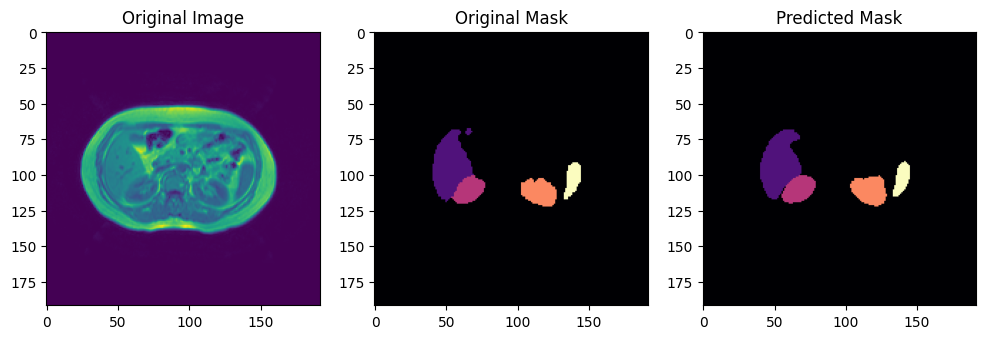

IoU per classe 0: 0.991870876531574  -Background
IoU per classe 1: 0.9280575539568345  -Liver
IoU per classe 2: nan  -Right kidney
IoU per classe 3: nan  -Left kidney
IoU per classe 4: 0.8600583090379009  -Spleen


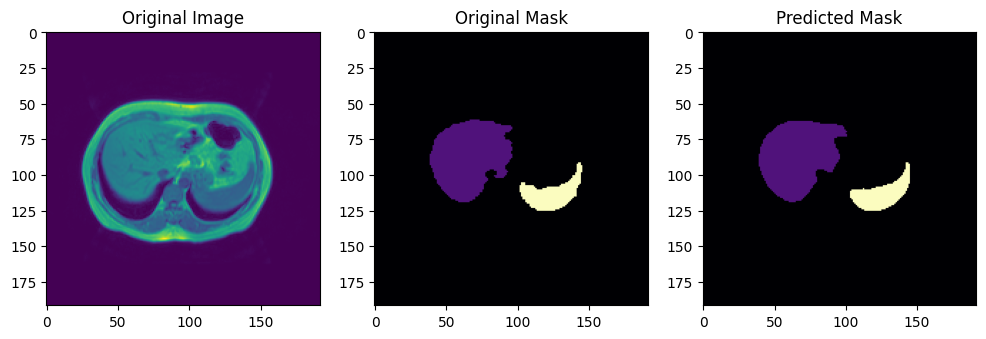

IoU per classe 0: 0.99951171875  -Background
IoU per classe 1: 0.0  -Liver
IoU per classe 2: nan  -Right kidney
IoU per classe 3: nan  -Left kidney
IoU per classe 4: nan  -Spleen


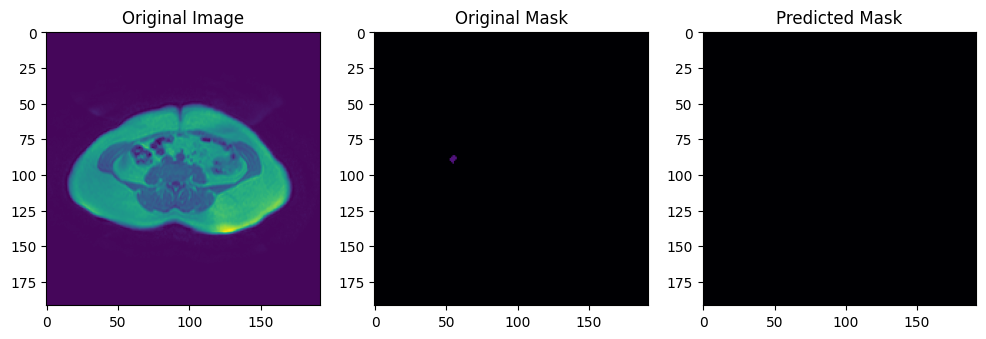

In [ ]:
# Define a function to plot triptychs for model predictions
def plot_triptychs(data, labels, index=None):
    # If index is not specified, randomly select one
    if index is None:
        index = np.random.randint(0, len(data))

    # Generate predictions for the selected index
    pred = model.predict(np.expand_dims(data[index], axis=0), verbose=0)
    pred = np.array(tf.math.argmax(pred, axis=-1))
    pred = np.reshape(pred, (192, 192, 1))

    #print accuracy
    print_calculate_iou(labels[index], np.squeeze(pred), num_classes)

    # Plot the original image, original mask, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(12, 12))
    axes[0].set_title("Original Image")
    axes[0].imshow(data[index])
    axes[1].set_title("Original Mask")
    colored_image = display_color_mapped_image_continuous(labels[index])
    axes[1].imshow(np.squeeze(colored_image))
    axes[2].set_title("Predicted Mask")
    colored_image = display_color_mapped_image_continuous(pred)
    axes[2].imshow(np.squeeze(colored_image))
    plt.show()

# Plot triptychs for three random samples from the test set
plot_triptychs(X_test, y_test)
plot_triptychs(X_test, y_test)
plot_triptychs(X_test, y_test)